## Taller de Programación en Python
### Profesor: Lucas Gómez Tobón

## Using APIs and Sentimental Analysis

### [Reddit API](https://www.reddit.com/dev/api/):
Go to [Reddit Apps](https://www.reddit.com/prefs/apps):
- Log in to your Reddit account and navigate to this page.
- Click "Create App" or "Create Another App".
- Choose the **script option**.
- Fill in the **Redirect URI**. You can use `http://localhost:8080` because is a local development.
- You will get a `Personal use script` and `Secret` values. 

**VERY IMPORTANT: you should treat these values as confidential credentials, similar to a password. Avoid directly embedding your credentials in your code, especially if you’re sharing the code on platforms like GitHub.**
> These credentials grant access to the Reddit API on behalf of your application. If someone else obtains them, they can misuse your app’s API access.


### How to secure your credentials and use it in Python
The easiest and most secure way to store credentials in a file and import them smoothly into Python is to use a `.env` file with `python-dotenv`:
1. Create a `.env` File. In the root directory of your project, create a file named `credentials.env`:
```
CLIENT_ID=your_personal_use_script
CLIENT_SECRET=your_secret
```
> **IMPORTANT NOTE** If you are using Git to manage your code versions, you **MUST** add `credentials.env` to `.gitignore.` to prevent sharing this information with unintended third parties.

2. Install `python-dotenv`. Install the `python-dotenv` package if you don’t already have it:
```bash
pip install python-dotenv
```
3. Load the `.env` File in Python

In [ ]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv('credentials.env')

# Retrieve the credentials
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

- Install the Python Reddit API Wrapper (`praw`) library: 
```bash
pip install praw
```

In [ ]:
import praw

# Configure the Reddit API
reddit = praw.Reddit(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    redirect_uri = "http://localhost:8080",
    user_agent = "Clase_Python_F24"
)

In [ ]:
# Generate the authorization URL
auth_url = reddit.auth.url(
    scopes=["read"], # This will determine what we can and can't do without this API
    state="uniqueKey", 
    duration="permanent"
)

print("Visit this URL to authorize your app:", auth_url)

In [ ]:
# After authorization, you'll get a code in the URL
# Example: http://localhost:8080/?state=uniqueKey&code=AUTH_CODE#_
# Replace AUTH_CODE below with the code you receive
auth_code = "-afJeo-ETMY7_KOeR_cPTX7RckHtQw" # NOT INCLUDE THE LAST #_

# Use the auth code to get an access token
token = reddit.auth.authorize(auth_code)
print("Access token:", token)

We want to get the latest post from the [Bitcoin subreddit](https://www.reddit.com/r/Bitcoin/)

In [ ]:
# Access the Bitcoin subreddit
subreddit = reddit.subreddit('Bitcoin')
latest_posts = subreddit.new(limit = 1000)

In [ ]:
# Example with one post!

# latest_post is an iterable
post_i = next(latest_posts)

In [ ]:
post_info = {
        'title': post_i.title, # Post title
        'content': post_i.selftext, # Post body (if any)
        'url': post_i.url, # Post URL
        'score': post_i.score, # Upvotes - Downvotes
        'num_comments': post_i.num_comments, # Number of comments
        'comments': [] # To store comments
    }

post_info

In [ ]:
post_i.comments.replace_more(limit=None)
comments = post_i.comments.list()
comments

In [ ]:
post_info['comments'].append({
    'author': str(comments[0].author),
    'content': comments[0].body,
    'score': comments[0].score
        })
    
post_info

### Collect in a Data Frame

In [ ]:
import time
import datetime
from tqdm import tqdm

# Collect the 1000 posts and its comments in a Data Frame
data = []  # Use a list to store rows temporarily

# Convert the generator to a list to calculate size
latest_posts = list(latest_posts)
                    
for p in tqdm(latest_posts):
    data.append({
        'title': p.title, # Post title
        'content': p.selftext, # Post body (if any)
        'author': str(p.author),
        'url': p.url, # Post URL
        'score': p.score, # Upvotes - Downvotes
        'num_comments': p.num_comments, # Number of comments
        'created_date': datetime.datetime.fromtimestamp(p.created_utc, datetime.UTC).strftime('%Y-%m-%d'),
        'created_time': datetime.datetime.fromtimestamp(p.created_utc, datetime.UTC).strftime('%H:%M:%S'),
        "type": "Post"
    })

    if p.num_comments > 0:
        # Expand all comments
        p.comments.replace_more(limit=None)  

        # Flatten the comment tree into a list
        MAX_RETRIES = 5
        for attempt in range(MAX_RETRIES):
            try:
                # Flatten the comment tree into a list
                all_comments = p.comments.list()
                # Exit the loop if successful
                break  
            except praw.exceptions.ServerError:
                print(f"Server error occurred. Retrying... ({attempt + 1}/{MAX_RETRIES})")
                time.sleep(5)  
        else:
            print("Failed to retrieve data after multiple attempts.")
            # Skips the remaining code for the current p (post) and moves directly to the 
            # next post in latest_posts.
            continue

        if len(all_comments) >= 20:
            # Sort comments by score (upvotes) in descending order
            sorted_comments = sorted(all_comments, key=lambda c: c.score, reverse=True)

            # Retrieve up to the top 20 most upvoted comments
            top_comments = sorted_comments[:20]

            all_comments = top_comments

        for c in all_comments:
            data.append({
                'content': c.body,  # The text content of the comment
                'author': str(c.author),   # Author of the comment
                'score': c.score, # Upvotes - Downvotes
                'created_date': datetime.datetime.fromtimestamp(c.created_utc, datetime.UTC).strftime('%Y-%m-%d'),
                'created_time': datetime.datetime.fromtimestamp(c.created_utc, datetime.UTC).strftime('%H:%M:%S'),
                'type': 'Comment'
            })

In [ ]:
import pandas as pd

bitcoin = pd.DataFrame(data)

In [ ]:
bitcoin["text"] = bitcoin["title"].fillna("") + " " + bitcoin["content"].fillna("")
bitcoin['num_comments'] = bitcoin['num_comments'].fillna(0)

In [ ]:
bitcoin.to_csv("bitcoin_reddit.csv", sep = ";", index = False)

In [ ]:
bitcoin.head()

## Sentimental Analysis

In [1]:
import pandas as pd 

bitcoin = pd.read_csv("bitcoin_reddit.csv", sep = ";")

In [2]:
bitcoin.shape

(9660, 10)

In [3]:
bitcoin.head()

,title,content,author,url,score,num_comments,created_date,created_time,type,text
0,Miles to go before I sleep…,NaN,Nirbhik,https://i.redd.it/c6m3kzlqoe2e1.jpeg,23,0.0,2024-11-22,07:33:23,Post,Miles to go before I sleep…
1,It's over 99000!!!,NaN,No-Research8107,https://i.redd.it/14kzzl3coe2e1.gif,257,4.0,2024-11-22,07:31:33,Post,It's over 99000!!!
2,NaN,100k legendary wall about to fall,tommy4019,NaN,9,0.0,2024-11-22,07:37:53,Comment,100k legendary wall about to fall
3,NaN,Non-believers: What!? 99000!? There's no way t...,MofoFTW,NaN,3,0.0,2024-11-22,14:37:09,Comment,Non-believers: What!? 99000!? There's no way ...
4,NaN,Remember when bitcoin was only $9000? Vegeta r...,nicsenespomnem,NaN,3,0.0,2024-11-22,15:53:46,Comment,Remember when bitcoin was only $9000? Vegeta ...


In [ ]:
# !pip install 'transformers[torch]'

In [ ]:
# !pip install torch torchvision torchaudio

In [9]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 0 # Use the first GPU
else:
    print("GPU is not available.")
    device = -1

GPU is not available.


Models:
- [bertweet-sentiment-analysis](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis?text=to+the+moon%21)
- [DistilRoberta-financial-sentiment](https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis?text=To+the+moon)

### Bertweet

In [14]:
# !pip install emoji==0.6.0

In [111]:
from transformers import pipeline

pipe_bert = pipeline("text-classification", 
                     model = "finiteautomata/bertweet-base-sentiment-analysis",
                     device = device,
                     # Return scores for all classes
                     top_k = None,
                     # batch_size = 2
                     ) 

In [71]:
result = pipe_bert(["Hello!", 
                    'Goodbye, you broke my heart.', 
                    "I love you!"])

result

[[{'label': 'NEU', 'score': 0.574583113193512},
  {'label': 'POS', 'score': 0.4192067086696625},
  {'label': 'NEG', 'score': 0.006210147403180599}],
 [{'label': 'NEG', 'score': 0.9746838808059692},
  {'label': 'NEU', 'score': 0.0203066598623991},
  {'label': 'POS', 'score': 0.005009472835808992}],
 [{'label': 'POS', 'score': 0.9921646118164062},
  {'label': 'NEU', 'score': 0.004897412844002247},
  {'label': 'NEG', 'score': 0.002938014455139637}]]

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
# model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

In [118]:
# The maximum sequence length supported by the model (128 tokens). When this happens, the model will 
# encounter indexing errors because it cannot process sequences longer than its limit.
mega_love = ["I love you "*100]
pipe_bert(mega_love)

Token indices sequence length is longer than the specified maximum sequence length for this model (302 > 128). Running this sequence through the model will result in indexing errors


IndexError: index out of range in self

In [124]:
# Do you think there is a better option?
bitcoin["trim_text"] = bitcoin["text"].apply(lambda x: x[0:128])

In [138]:
bitcoin["score"].describe()

count    9660.000000
mean       31.705487
std       199.974172
min       -17.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      9252.000000
Name: score, dtype: float64

In [141]:
negative_scores = bitcoin.loc[bitcoin["score"] < 0, ]
print(negative_scores.shape)
negative_scores.head()

(108, 11)


,title,content,author,url,score,num_comments,created_date,created_time,type,text,trim_text
596,NaN,"once it hits 100k, it'll drop 15-20%. DONE.",Agreeable_Tie7697,NaN,-4,0.0,2024-11-22,00:37:38,Comment,"once it hits 100k, it'll drop 15-20%. DONE.","once it hits 100k, it'll drop 15-20%. DONE."
732,NaN,Great English lol,leakyripper,NaN,-7,0.0,2024-11-21,22:12:03,Comment,Great English lol,Great English lol
734,NaN,OTC Bitcoin? That's not a thing 😆,JuxtaposeLife,NaN,-2,0.0,2024-11-21,23:27:03,Comment,OTC Bitcoin? That's not a thing 😆,OTC Bitcoin? That's not a thing 😆
748,NaN,Worse. Then better. Too many are too far behin...,joesus-christ,NaN,-1,0.0,2024-11-21,21:59:27,Comment,Worse. Then better. Too many are too far behi...,Worse. Then better. Too many are too far behi...
924,NaN,i only have etfs,Apprehensive_Two1528,NaN,-3,0.0,2024-11-21,19:50:11,Comment,i only have etfs,i only have etfs


In [148]:
positive_scores = bitcoin.sort_values("score", ascending = False).iloc[0:100]
print(positive_scores.shape)
positive_scores.head()

(100, 11)


,title,content,author,url,score,num_comments,created_date,created_time,type,text,trim_text
1493,Sold .16 BTC to pay off my car! 🧘🐋🥂,"Was contemplating doing this transaction, but ...",Eddy2106,https://i.redd.it/wydd1tqve92e1.jpeg,9252,900.0,2024-11-21,13:49:13,Post,Sold .16 BTC to pay off my car! 🧘🐋🥂 Was contem...,Sold .16 BTC to pay off my car! 🧘🐋🥂 Was contem...
5467,throwback to 2019 when my friend was trying to...,NaN,jiar300,https://i.redd.it/m0389ve2rt1e1.jpeg,6322,268.0,2024-11-19,09:09:01,Post,throwback to 2019 when my friend was trying to...,throwback to 2019 when my friend was trying to...
5005,Me buying at $92k,NaN,SatisfactionFinal287,https://i.redd.it/y04anu2w5w1e1.jpeg,6027,224.0,2024-11-19,17:15:40,Post,Me buying at $92k,Me buying at $92k
2546,Omg wtf is happening!!,NaN,James1997lol,https://i.redd.it/fe7wcdfah62e1.jpeg,3816,1052.0,2024-11-21,03:57:23,Post,Omg wtf is happening!!,Omg wtf is happening!!
1304,Queued up a celebratory purchase at $100K,"nm, you?",skeetskeetamirite,https://i.redd.it/ip1bukkdca2e1.jpeg,3720,190.0,2024-11-21,16:56:58,Post,"Queued up a celebratory purchase at $100K nm, ...","Queued up a celebratory purchase at $100K nm, ..."


In [151]:
sample_reddit = pd.concat([positive_scores, negative_scores]).reset_index(drop = True)

In [152]:
# Apply the model to all the column
sample_reddit["scores"] = sample_reddit["trim_text"].apply(lambda x: pipe_bert(x))

In [154]:
sample_reddit["scores"].head()

0    [[{'label': 'NEU', 'score': 0.7715205550193787...
1    [[{'label': 'NEU', 'score': 0.9319330453872681...
2    [[{'label': 'NEU', 'score': 0.9674603939056396...
3    [[{'label': 'NEG', 'score': 0.9551398158073425...
4    [[{'label': 'NEU', 'score': 0.7418627738952637...
Name: scores, dtype: object

In [155]:
sample_reddit["scores"][0]

[[{'label': 'NEU', 'score': 0.7715205550193787},
  {'label': 'POS', 'score': 0.2247435301542282},
  {'label': 'NEG', 'score': 0.003735897596925497}]]

In [ ]:
def extract_scores(row):
    scores = {entry['label']: entry['score'] for entry in row}
    return pd.Series(scores)

# Apply the function to create separate columns
sample_sentiments = sample_reddit["scores"].apply(lambda x: extract_scores(x[0]))
sample_sentiments

,NEU,POS,NEG
0,0.771521,0.224744,0.003736
1,0.931933,0.064091,0.003976
2,0.967460,0.022409,0.010131
3,0.038818,0.006043,0.955140
4,0.741863,0.256059,0.002078
...,...,...,...
203,0.968075,0.011676,0.020249
204,0.947758,0.011613,0.040629
205,0.087764,0.908925,0.003312
206,0.023922,0.974811,0.001267


In [261]:
print(bitcoin["text"][1])
pipe_bert(bitcoin["text"][1])

It's over 99000!!! 


[[{'label': 'NEU', 'score': 0.7552030086517334},
  {'label': 'POS', 'score': 0.1816788911819458},
  {'label': 'NEG', 'score': 0.0631181076169014}]]

In [262]:
print(bitcoin["text"][2])
pipe_bert(bitcoin["text"][2])

 100k legendary wall about to fall


[[{'label': 'NEU', 'score': 0.9116183519363403},
  {'label': 'POS', 'score': 0.048670414835214615},
  {'label': 'NEG', 'score': 0.039711154997348785}]]

In [239]:
sample_sentiments["NEU"] = 0
sample_sentiments["POS"] = sample_sentiments["POS"]/(sample_sentiments["POS"] + sample_sentiments["NEG"])
sample_sentiments["NEG"] = sample_sentiments["NEG"]/(sample_sentiments["POS"] + sample_sentiments["NEG"])

In [ ]:
# sample_reddit = sample_reddit.iloc[:, 0:12]

In [245]:
sample_reddit = pd.concat([sample_reddit, sample_sentiments], axis = 1)
sample_reddit

,title,content,author,url,score,num_comments,created_date,created_time,type,text,trim_text,scores,NEU,POS,NEG
0,Sold .16 BTC to pay off my car! 🧘🐋🥂,"Was contemplating doing this transaction, but ...",Eddy2106,https://i.redd.it/wydd1tqve92e1.jpeg,9252,900.0,2024-11-21,13:49:13,Post,Sold .16 BTC to pay off my car! 🧘🐋🥂 Was contem...,Sold .16 BTC to pay off my car! 🧘🐋🥂 Was contem...,"[[{'label': 'NEU', 'score': 0.7715205550193787...",0,0.983649,0.003784
1,throwback to 2019 when my friend was trying to...,NaN,jiar300,https://i.redd.it/m0389ve2rt1e1.jpeg,6322,268.0,2024-11-19,09:09:01,Post,throwback to 2019 when my friend was trying to...,throwback to 2019 when my friend was trying to...,"[[{'label': 'NEU', 'score': 0.9319330453872681...",0,0.941586,0.004205
2,Me buying at $92k,NaN,SatisfactionFinal287,https://i.redd.it/y04anu2w5w1e1.jpeg,6027,224.0,2024-11-19,17:15:40,Post,Me buying at $92k,Me buying at $92k,"[[{'label': 'NEU', 'score': 0.9674603939056396...",0,0.688665,0.014497
3,Omg wtf is happening!!,NaN,James1997lol,https://i.redd.it/fe7wcdfah62e1.jpeg,3816,1052.0,2024-11-21,03:57:23,Post,Omg wtf is happening!!,Omg wtf is happening!!,"[[{'label': 'NEG', 'score': 0.9551398158073425...",0,0.006287,0.993461
4,Queued up a celebratory purchase at $100K,"nm, you?",skeetskeetamirite,https://i.redd.it/ip1bukkdca2e1.jpeg,3720,190.0,2024-11-21,16:56:58,Post,"Queued up a celebratory purchase at $100K nm, ...","Queued up a celebratory purchase at $100K nm, ...","[[{'label': 'NEU', 'score': 0.7418627738952637...",0,0.991951,0.002090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,NaN,How much is a significant amount?,JustinCompton79,NaN,-1,0.0,2024-11-16,17:03:08,Comment,How much is a significant amount?,How much is a significant amount?,"[[{'label': 'NEU', 'score': 0.9680748581886292...",0,0.365736,0.052460
204,NaN,I may get roasted but after taking a look at m...,CR0Wmurder,NaN,-2,0.0,2024-11-16,11:52:22,Comment,I may get roasted but after taking a look at ...,I may get roasted but after taking a look at ...,"[[{'label': 'NEU', 'score': 0.9477577805519104...",0,0.222287,0.154533
205,NaN,And a million bitcoin is 10 000 hundreds of bi...,MiceAreTiny,NaN,-9,0.0,2024-11-16,09:27:50,Comment,And a million bitcoin is 10 000 hundreds of b...,And a million bitcoin is 10 000 hundreds of b...,"[[{'label': 'POS', 'score': 0.9089245200157166...",0,0.996369,0.003313
206,NaN,"Hey, thanks for the welcome, Neo! But trust me...",oldjambalaya69,NaN,-1,0.0,2024-11-16,06:17:00,Comment,"Hey, thanks for the welcome, Neo! But trust m...","Hey, thanks for the welcome, Neo! But trust m...","[[{'label': 'POS', 'score': 0.9748110771179199...",0,0.998702,0.001267


In [246]:
sample_reddit.sort_values("NEG", ascending = False)["text"].iloc[0]

' Is swan an exchange and where the fuck did you hear about this garbage place.   Bitcoin is not designed to be traded it’s designed to be a functioning “ commodity “ and for some ungodly reason exchanges think that can do shady shit.  Get that shit out and send it to “ ROCK WALLET”.  Or “ HAND CASH”.  The ORIGINAL BITCOIN PROTOCOL'

In [247]:
sample_reddit.sort_values("NEG", ascending = False)["text"].iloc[1]

' She can’t figure out how to treat humans decently, so BTC would be beyond her.'

In [248]:
sample_reddit.sort_values("NEG", ascending = False)["text"].iloc[2]

' Honestly? Not great.\n\nNot shitting on Bitcoin, but I would expect to 10x my money in 15 years on the stock market or I have really fucked up.'

In [249]:
sample_reddit.sort_values("POS", ascending = False)["text"].iloc[0]

" The good... Bought a median house in a beach town. Traveled more than most. Created some fun revenue streams. Bought a literal shit ton of VOO to diversify. \n\nThe bad... Paid 200k in hospital bills to save my life from a failed liver and suicide attempt. Went to a psych ward and a rehab. Twice. Lost everything that mattered in life other than my financial security.\n\nMoney isn't everything. Time is. Enjoy life while you stack your sats.\n\nEdited to add that I've been sober over 2 years now and got my sanity back."

In [250]:
sample_reddit.sort_values("POS", ascending = False)["text"].iloc[1]

'Bitcoin is the currency of freedom says Robert F. Kennedy Jr Very bullish to see such a strong support from leaders like RFK and so many others.\n\n "Bitcoin is the currency of freedom , a hedge against inflation for middle class Americans, a remedy against the dollar’s downgrade from the world’s reserve currency, and the offramp from a ruinous national debt. Bitcoin will have no stronger advocate than Howard Lutnik."\n\n[https://x.com/RobertKennedyJr/status/1857844634879152540](https://x.com/RobertKennedyJr/status/1857844634879152540)'

In [251]:
sample_reddit.sort_values("POS", ascending = False)["text"].iloc[2]

'No matter the amount, everyone here should buy btc at 100k to celebrate To celebrate this historical milestone, let’s all collective buy a bit of btc and contribute pushing this gift to mankind a little further up its journey!'

In [ ]:
import numpy as np

sample_reddit["created_date"] = pd.to_datetime(sample_reddit["created_date"])
np.sort(sample_reddit["created_date"].unique())

array(['2024-11-16T00:00:00.000000000', '2024-11-17T00:00:00.000000000',
       '2024-11-18T00:00:00.000000000', '2024-11-19T00:00:00.000000000',
       '2024-11-20T00:00:00.000000000', '2024-11-21T00:00:00.000000000',
       '2024-11-22T00:00:00.000000000'], dtype='datetime64[ns]')

In [255]:
daily_emotions = sample_reddit.groupby(["created_date"])[["POS", "NEU", "NEG"]].mean().reset_index()
daily_emotions

,created_date,POS,NEU,NEG
0,2024-11-16,0.541301,0.0,0.301422
1,2024-11-17,0.655189,0.0,0.235326
2,2024-11-18,0.451470,0.0,0.453373
3,2024-11-19,0.471886,0.0,0.404238
4,2024-11-20,0.494899,0.0,0.358528
5,2024-11-21,0.520906,0.0,0.356597
6,2024-11-22,0.646183,0.0,0.191924


$$CI = \bar{x} \pm z \frac{\sigma}{\sqrt{n}}$$

In [256]:
# Calculate a confidence interval as well.
n = len(sample_reddit['NEG'])

sigma_neg = sample_reddit['NEG'].std()
sigma_pos = sample_reddit['POS'].std()
sigma_neu = sample_reddit['NEU'].std()

ci_neg = 1.96 * sigma_neg / np.sqrt(n)
ci_pos = 1.96 * sigma_pos / np.sqrt(n)
ci_neu = 1.96 * sigma_neu / np.sqrt(n)

# A z-score of 1.96 is associated with a 95% confidence level
daily_emotions['NEG_CI_low'] = daily_emotions['NEG'] - ci_neg
daily_emotions['NEG_CI_high'] = daily_emotions['NEG'] + ci_neg

daily_emotions['POS_CI_low'] = daily_emotions['POS'] - ci_pos
daily_emotions['POS_CI_high'] = daily_emotions['POS'] + ci_pos

daily_emotions['NEU_CI_low'] = daily_emotions['NEU'] - ci_neu
daily_emotions['NEU_CI_high'] = daily_emotions['NEU'] + ci_neu


daily_emotions

,created_date,POS,NEU,NEG,NEG_CI_low,NEG_CI_high,POS_CI_low,POS_CI_high,NEU_CI_low,NEU_CI_high
0,2024-11-16,0.541301,0.0,0.301422,0.244468,0.358375,0.484987,0.597614,0.0,0.0
1,2024-11-17,0.655189,0.0,0.235326,0.178373,0.292279,0.598876,0.711502,0.0,0.0
2,2024-11-18,0.451470,0.0,0.453373,0.396420,0.510326,0.395156,0.507783,0.0,0.0
3,2024-11-19,0.471886,0.0,0.404238,0.347285,0.461191,0.415573,0.528200,0.0,0.0
4,2024-11-20,0.494899,0.0,0.358528,0.301575,0.415481,0.438586,0.551212,0.0,0.0
5,2024-11-21,0.520906,0.0,0.356597,0.299644,0.413550,0.464592,0.577219,0.0,0.0
6,2024-11-22,0.646183,0.0,0.191924,0.134970,0.248877,0.589869,0.702496,0.0,0.0


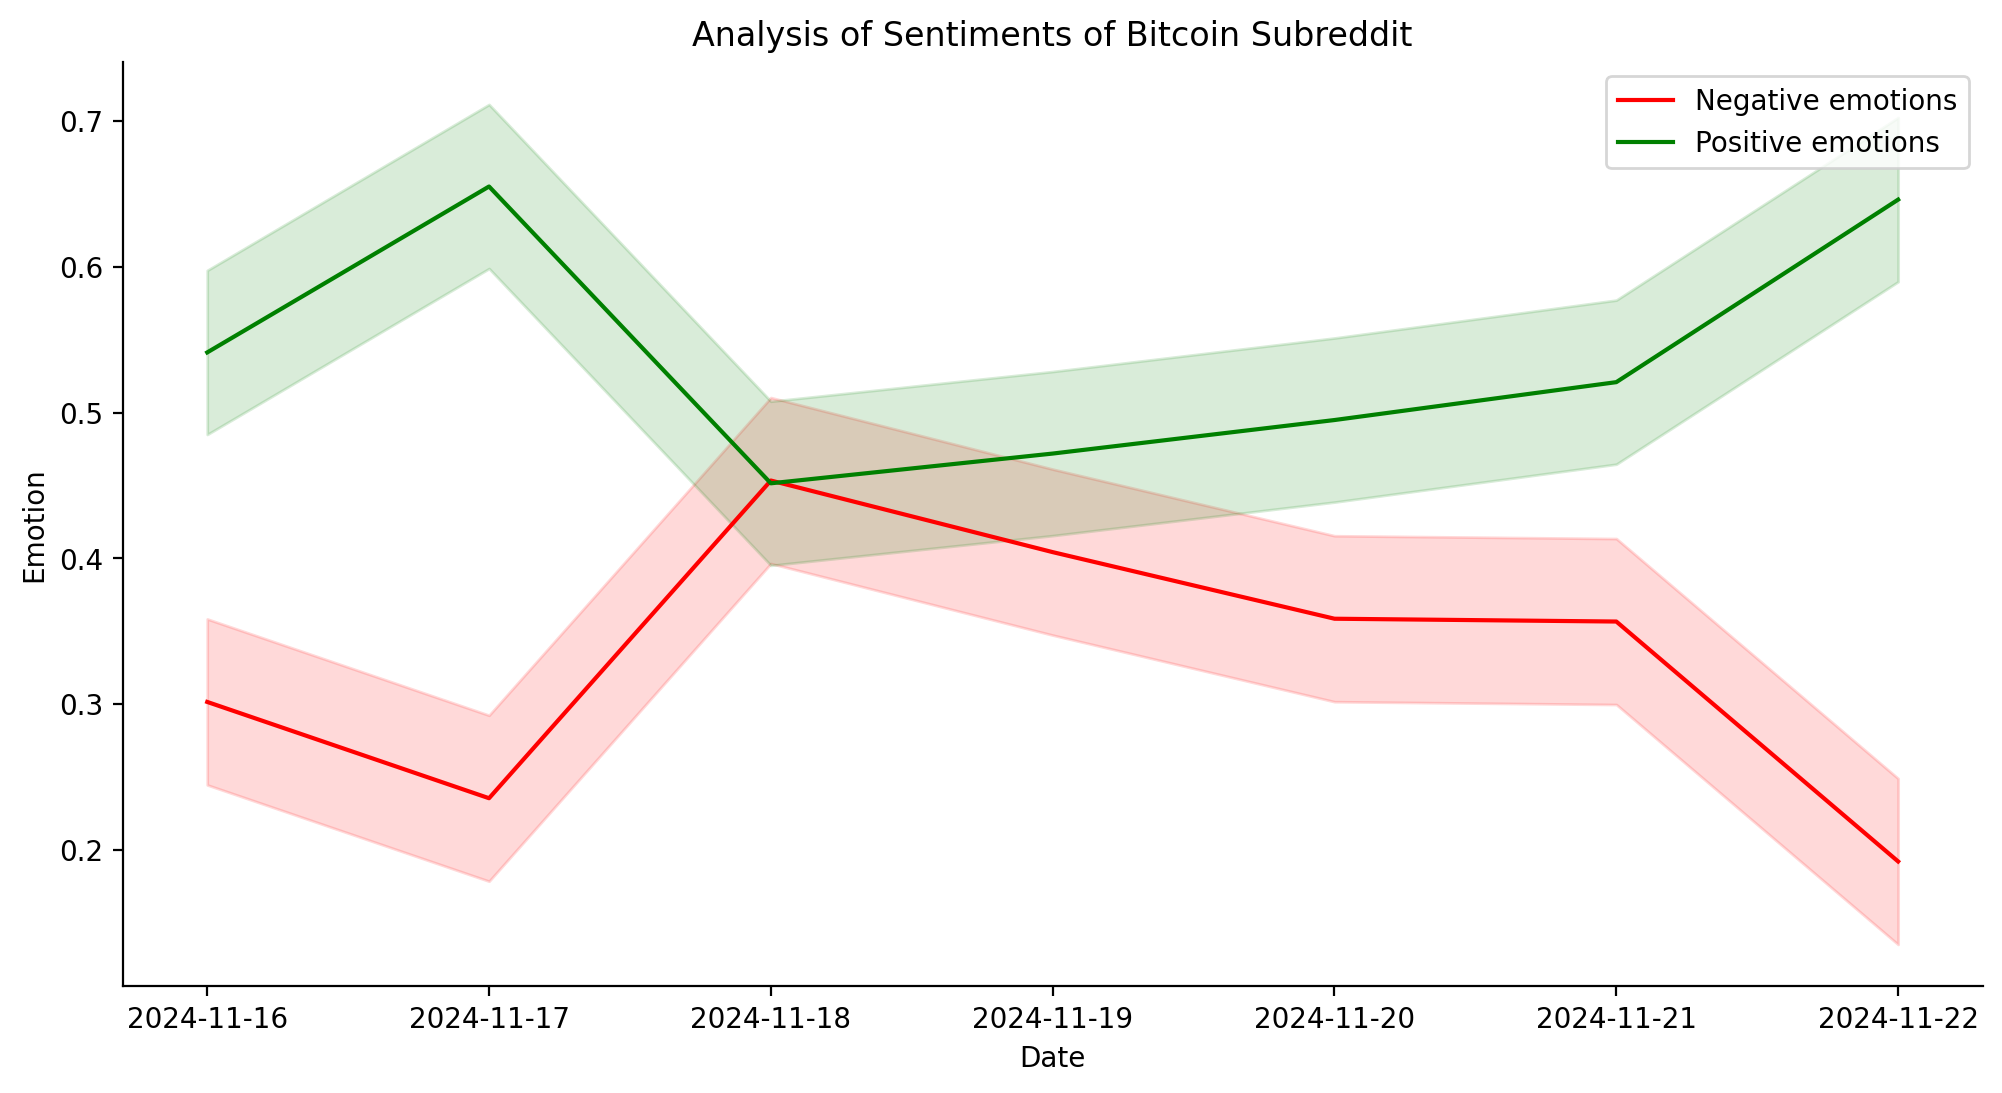

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 6), dpi = 200)
sns.despine()

# Negative
plt.plot(daily_emotions["created_date"], daily_emotions["NEG"], color = 'red', label = "Negative emotions")
ax.fill_between(daily_emotions["created_date"], 
                daily_emotions['NEG_CI_low'], 
                daily_emotions['NEG_CI_high'], color = 'red', alpha = .15)

# Positive
plt.plot(daily_emotions["created_date"], daily_emotions["POS"], color = 'green', label = "Positive emotions")
ax.fill_between(daily_emotions["created_date"], 
                daily_emotions['POS_CI_low'], 
                daily_emotions['POS_CI_high'], color = 'green', alpha = .15)

plt.title("Sentiment Analysis of the Bitcoin Subreddit")
plt.xlabel("Date")
plt.ylabel("Emotion")
plt.legend()

### DistilRoberta Financial

In [112]:
pipe_finance = pipeline("text-classification", 
                        model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
                        device = device,
                        top_k = None)

In [ ]:
# Load model directly
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
# model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

In [113]:
pipe_finance(["Hello!", 
              'Goodbye, you broke my heart.', 
              "I love you!"])

[[{'label': 'neutral', 'score': 0.9998531341552734},
  {'label': 'positive', 'score': 7.464474765583873e-05},
  {'label': 'negative', 'score': 7.221168198157102e-05}],
 [{'label': 'neutral', 'score': 0.9874181747436523},
  {'label': 'negative', 'score': 0.010220942087471485},
  {'label': 'positive', 'score': 0.0023608694318681955}],
 [{'label': 'neutral', 'score': 0.9995593428611755},
  {'label': 'positive', 'score': 0.0003504788037389517},
  {'label': 'negative', 'score': 9.01454477570951e-05}]]